

Implementation of LSTM Model on EUR-JPU prediction of the close price 12 hour ahead based on previous 24 hours

## 1. Data Preparation

### 1.1 Read in data file

In [1]:
import talib as ta

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from utils import series_to_supervised

In [2]:
data = pd.read_csv('../data/EUR_JPY_H1.csv')
data

,datetime,open,high,low,close
0,2005-01-02T18:00:00.000000000Z,139.100,139.110,139.050,139.050
1,2005-01-02T19:00:00.000000000Z,139.160,139.300,139.090,139.200
2,2005-01-02T20:00:00.000000000Z,139.200,139.250,139.030,139.120
3,2005-01-02T21:00:00.000000000Z,139.110,139.280,139.110,139.170
4,2005-01-02T22:00:00.000000000Z,139.160,139.220,139.110,139.190
...,...,...,...,...,...
103072,2021-02-26T18:00:00.000000000Z,128.826,128.826,128.738,128.758
103073,2021-02-26T19:00:00.000000000Z,128.762,128.822,128.676,128.782
103074,2021-02-26T20:00:00.000000000Z,128.784,128.792,128.594,128.594
103075,2021-02-26T21:00:00.000000000Z,128.598,128.680,128.563,128.655


### 1.2 Datetime formatting

In [3]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['datetime'] = data['datetime'].dt.tz_localize(None)
# data.set_index('datetime', inplace=True)
data

,datetime,open,high,low,close
0,2005-01-02 18:00:00,139.100,139.110,139.050,139.050
1,2005-01-02 19:00:00,139.160,139.300,139.090,139.200
2,2005-01-02 20:00:00,139.200,139.250,139.030,139.120
3,2005-01-02 21:00:00,139.110,139.280,139.110,139.170
4,2005-01-02 22:00:00,139.160,139.220,139.110,139.190
...,...,...,...,...,...
103072,2021-02-26 18:00:00,128.826,128.826,128.738,128.758
103073,2021-02-26 19:00:00,128.762,128.822,128.676,128.782
103074,2021-02-26 20:00:00,128.784,128.792,128.594,128.594
103075,2021-02-26 21:00:00,128.598,128.680,128.563,128.655


### 1.3 TA indicators

In [4]:
open_ = data['open'].values
high_ = data['high'].values
low_ = data['low'].values
close_ = data['close'].values
dt = data.index

In [5]:
# overlap studies indicators
data['sma24_H'] = ta.SMA(high_, timeperiod=24)            ## simple moving average of high price
data['sma24_L'] = ta.SMA(low_, timeperiod=24)             ## simple moving average of low price
data['midprice'] = ta.MIDPRICE(high_, low_, timeperiod=24)    ## mid price
## data['sar'] = ta.SAR(high_, low_, acceleration=0, maximum=0)  ## parabolic SAR

# momentum indicators
data['minus_dm'] = ta.MINUS_DM(high_, low_, 24)      ## minus direction movement
data['plus_dm'] = ta.PLUS_DM(high_, low_, 24)        ## plus direction movement 
data['mom_H'] = ta.MOM(high_, 24)    ## momentum of high price
# data['mom_L'] = ta.MOM(low_, 24)     ## momentum of low price
data['roc_H'] = ta.ROC(high_, 24)    ## ROC(rate of change) of high price
# data['roc_L'] = ta.ROC(low_, 24)     ## ROC(rate of change) of low price
data['rsi_H'] = ta.RSI(high_, 24)    ## RSI(relative strength index) of high price
# data['rsi_L'] = ta.RSI(low_, 24)     ## RSI(relative strength index) of low price
data['macd_H'] = ta.MACD(high_, fastperiod=24, slowperiod=48, signalperiod=12)[0]    ## MACD(moving average convergence/divergence) of high price
# data['macd_L'] = ta.MACD(low_, fastperiod=24, slowperiod=48, signalperiod=12)[0]     ## MACD(moving average convergence/divergence) of high price
data['aroonosc'] = ta.AROONOSC(high_, low_, timeperiod=24)    ## aroon oscillator

data['adx'] = ta.ADX(high_, low_, open_, timeperiod=24)    ## average directional movement index


In [6]:
data.dropna(axis=0, inplace=True)
data = data.reset_index(drop=True)
print('shape of data: ', data.shape)
data

shape of data:  (103019, 16)


,datetime,open,high,low,close,sma24_H,sma24_L,midprice,minus_dm,plus_dm,mom_H,roc_H,rsi_H,macd_H,aroonosc,adx
0,2005-01-05 04:00:00,138.595,138.695,138.485,138.545,138.705000,138.420000,138.4200,1.235349,1.037381,0.220,0.158873,48.010573,-0.083954,45.833333,15.051210
1,2005-01-05 05:00:00,138.555,138.655,138.515,138.605,138.711667,138.427500,138.4200,1.183876,0.994157,0.160,0.115528,47.220217,-0.082418,45.833333,14.787017
2,2005-01-05 06:00:00,138.625,138.695,138.555,138.615,138.717500,138.439167,138.4200,1.134548,0.992734,0.140,0.101043,48.111550,-0.079227,45.833333,14.448660
3,2005-01-05 07:00:00,138.605,138.895,138.565,138.815,138.741667,138.465000,138.4200,1.087275,1.151370,0.580,0.419333,52.313237,-0.068316,45.833333,13.965928
4,2005-01-05 08:00:00,138.815,138.905,138.655,138.665,138.771667,138.499167,138.5100,1.041972,1.113396,0.720,0.521041,52.513857,-0.058072,45.833333,13.522089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103014,2021-02-26 18:00:00,128.826,128.826,128.738,128.758,129.171000,128.929750,129.0830,1.332770,1.196959,-1.036,-0.797770,44.607791,0.053467,-54.166667,20.095267
103015,2021-02-26 19:00:00,128.762,128.822,128.676,128.782,129.145333,128.910750,129.0830,1.339238,1.147086,-0.616,-0.475904,44.538548,0.038357,-33.333333,19.579978
103016,2021-02-26 20:00:00,128.784,128.792,128.594,128.594,129.118417,128.883292,129.0590,1.365436,1.099291,-0.646,-0.499081,44.003979,0.023722,-87.500000,19.214069
103017,2021-02-26 21:00:00,128.598,128.680,128.563,128.655,129.088458,128.854833,129.0435,1.339543,1.053487,-0.719,-0.555646,42.038386,0.006342,-91.666667,18.911554


### 1.4 EDA

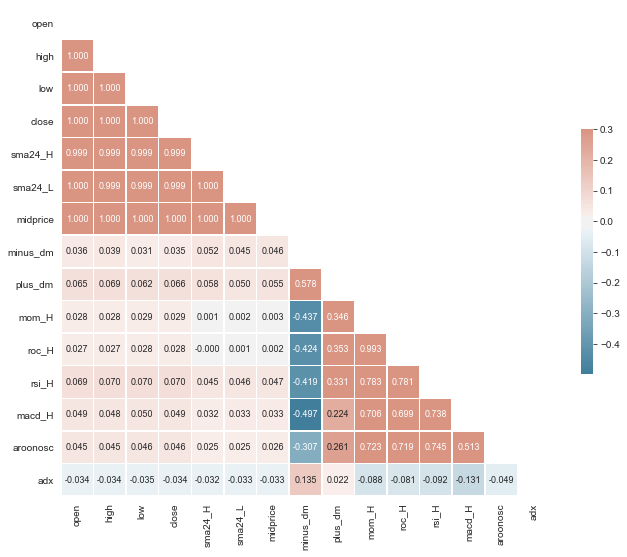

In [7]:
## correlation heatmap

sns.set_style('whitegrid')

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
## ref.https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            annot=True, 
            fmt='.3f',   # ref. https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format
            annot_kws={'fontsize': 9 },
            cbar_kws={"shrink": .5})
plt.show()


## auto-encoder for feature selection

In [8]:
data.columns.to_list()

['datetime',
 'open',
 'high',
 'low',
 'close',
 'sma24_H',
 'sma24_L',
 'midprice',
 'minus_dm',
 'plus_dm',
 'mom_H',
 'roc_H',
 'rsi_H',
 'macd_H',
 'aroonosc',
 'adx']

In [9]:
# ## define features and target
# columns = data.columns.to_list()
# features = [ feature for feature in columns if feature not in ['datetime', 'close']]
# target = ['close']

In [10]:
data.iloc[:,1:]

,open,high,low,close,sma24_H,sma24_L,midprice,minus_dm,plus_dm,mom_H,roc_H,rsi_H,macd_H,aroonosc,adx
0,138.595,138.695,138.485,138.545,138.705000,138.420000,138.4200,1.235349,1.037381,0.220,0.158873,48.010573,-0.083954,45.833333,15.051210
1,138.555,138.655,138.515,138.605,138.711667,138.427500,138.4200,1.183876,0.994157,0.160,0.115528,47.220217,-0.082418,45.833333,14.787017
2,138.625,138.695,138.555,138.615,138.717500,138.439167,138.4200,1.134548,0.992734,0.140,0.101043,48.111550,-0.079227,45.833333,14.448660
3,138.605,138.895,138.565,138.815,138.741667,138.465000,138.4200,1.087275,1.151370,0.580,0.419333,52.313237,-0.068316,45.833333,13.965928
4,138.815,138.905,138.655,138.665,138.771667,138.499167,138.5100,1.041972,1.113396,0.720,0.521041,52.513857,-0.058072,45.833333,13.522089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103014,128.826,128.826,128.738,128.758,129.171000,128.929750,129.0830,1.332770,1.196959,-1.036,-0.797770,44.607791,0.053467,-54.166667,20.095267
103015,128.762,128.822,128.676,128.782,129.145333,128.910750,129.0830,1.339238,1.147086,-0.616,-0.475904,44.538548,0.038357,-33.333333,19.579978
103016,128.784,128.792,128.594,128.594,129.118417,128.883292,129.0590,1.365436,1.099291,-0.646,-0.499081,44.003979,0.023722,-87.500000,19.214069
103017,128.598,128.680,128.563,128.655,129.088458,128.854833,129.0435,1.339543,1.053487,-0.719,-0.555646,42.038386,0.006342,-91.666667,18.911554


## 2. Data Processing
### 2.1 Min-max scalling

In [11]:
values = data.iloc[:,1:].values

scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled.shape

(103019, 15)

### 2.2 Convert to supervised frame

In [12]:
reframed = series_to_supervised(scaled, 24, 12)
# reframed

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),...,var6(t+11),var7(t+11),var8(t+11),var9(t+11),var10(t+11),var11(t+11),var12(t+11),var13(t+11),var14(t+11),var15(t+11)
24,0.586997,0.586943,0.587196,0.586497,0.588340,0.586985,0.584973,0.071889,0.069448,0.471330,...,0.582022,0.582711,0.065315,0.079964,0.481508,0.465946,0.516582,0.499951,0.895833,0.150463
25,0.586468,0.586415,0.587593,0.587291,0.588429,0.587084,0.584973,0.068454,0.066033,0.468421,...,0.582210,0.582911,0.065491,0.076110,0.472299,0.458018,0.516582,0.501715,0.875000,0.141792
26,0.587394,0.586943,0.588122,0.587424,0.588507,0.587240,0.584973,0.065163,0.065920,0.467452,...,0.582332,0.582911,0.062990,0.072416,0.467937,0.454275,0.487767,0.502457,0.687500,0.133814
27,0.587130,0.589585,0.588255,0.590070,0.588828,0.587584,0.584973,0.062009,0.078457,0.488779,...,0.582504,0.582911,0.059926,0.068877,0.474238,0.459699,0.468233,0.502554,0.687500,0.126168
28,0.589907,0.589717,0.589446,0.588085,0.589228,0.588038,0.586171,0.058986,0.075456,0.495565,...,0.582698,0.582911,0.056990,0.076548,0.477631,0.462608,0.509613,0.503900,0.687500,0.121854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103003,0.460185,0.461805,0.460836,0.462784,0.457088,0.457508,0.456439,0.016307,0.071044,0.502932,...,0.460679,0.460724,0.078390,0.082059,0.410450,0.402149,0.432473,0.529098,0.229167,0.279601
103004,0.462672,0.466506,0.464251,0.467785,0.457613,0.458004,0.459406,0.015188,0.095696,0.506616,...,0.460426,0.460724,0.078821,0.078118,0.430808,0.420662,0.431560,0.525758,0.333333,0.270601
103005,0.467606,0.467616,0.468301,0.468050,0.458124,0.458544,0.459965,0.014116,0.097824,0.505259,...,0.460060,0.460404,0.080569,0.074341,0.429354,0.419329,0.424515,0.522524,0.062500,0.264210
103006,0.467870,0.470337,0.469360,0.469399,0.458788,0.459141,0.461336,0.013089,0.109506,0.518734,...,0.459682,0.460198,0.078842,0.070721,0.425816,0.416075,0.398613,0.518682,0.041667,0.258927


In [24]:
columns = reframed.columns.to_list()

In [25]:
selected_columns = []
for var in range(1, 16):
    for t in range(24, 0, -1):
        selected_columns.append('var'+str(var)+'(t-'+str(t)+')')
# selected_columns.append('var3(t+5)')
selected_columns.append('var3(t+11)')

In [28]:
# selected_columns

In [27]:
reframed = reframed[selected_columns]
reframed

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var15(t-9),var15(t-8),var15(t-7),var15(t-6),var15(t-5),var15(t-4),var15(t-3),var15(t-2),var15(t-1),var3(t+11)
24,0.586997,0.586468,0.587394,0.587130,0.589907,0.587923,0.590569,0.589114,0.584352,0.581177,...,0.204592,0.207161,0.209240,0.207076,0.208542,0.209947,0.213452,0.212098,0.210033,0.584152
25,0.586468,0.587394,0.587130,0.589907,0.587923,0.590569,0.589114,0.584352,0.581177,0.581177,...,0.207161,0.209240,0.207076,0.208542,0.209947,0.213452,0.212098,0.210033,0.206113,0.583490
26,0.587394,0.587130,0.589907,0.587923,0.590569,0.589114,0.584352,0.581177,0.581177,0.578664,...,0.209240,0.207076,0.208542,0.209947,0.213452,0.212098,0.210033,0.206113,0.208944,0.583358
27,0.587130,0.589907,0.587923,0.590569,0.589114,0.584352,0.581177,0.581177,0.578664,0.577738,...,0.207076,0.208542,0.209947,0.213452,0.212098,0.210033,0.206113,0.208944,0.208563,0.583622
28,0.589907,0.587923,0.590569,0.589114,0.584352,0.581177,0.581177,0.578664,0.577738,0.580780,...,0.208542,0.209947,0.213452,0.212098,0.210033,0.206113,0.208944,0.208563,0.204835,0.584152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103003,0.460185,0.462672,0.467606,0.467870,0.469312,0.470741,0.470635,0.468519,0.471706,0.471587,...,0.451376,0.434793,0.420429,0.406664,0.398713,0.391094,0.384575,0.374250,0.364415,0.458189
103004,0.462672,0.467606,0.467870,0.469312,0.470741,0.470635,0.468519,0.471706,0.471587,0.471971,...,0.434793,0.420429,0.406664,0.398713,0.391094,0.384575,0.374250,0.364415,0.363932,0.457368
103005,0.467606,0.467870,0.469312,0.470741,0.470635,0.468519,0.471706,0.471587,0.471971,0.471323,...,0.420429,0.406664,0.398713,0.391094,0.384575,0.374250,0.364415,0.363932,0.363470,0.456283
103006,0.467870,0.469312,0.470741,0.470635,0.468519,0.471706,0.471587,0.471971,0.471323,0.462037,...,0.406664,0.398713,0.391094,0.384575,0.374250,0.364415,0.363932,0.363470,0.356182,0.455873


### 2.3 Train, val, test split

In [32]:
# ## split fraction
# ## training : val : test = .7 : .1 : .2

values = reframed.values

n_train = int(len(values) * 0.7)
n_val = int(len(values) * 0.8)
train = values[: n_train, :]
val = values[n_train: n_val, :]
test = values[n_val:, :]

train_X, train_y = train[:,:-1], train[:,-1]
val_X, val_y = val[:,:-1], val[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]

In [36]:
## convert to 3D
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


## 3. LSTM model
### 3.1 Training model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import keras

In [43]:
# LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                82200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 82,251
Trainable params: 82,251
Non-trainable params: 0
_________________________________________________________________


In [45]:
## call back
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


## trainging model
history = model.fit(train_X, train_y, 
                    epochs=10000, batch_size=64,
                    validation_data=(val_X, val_y), 
                    callbacks=[es_callback, modelckpt_callback],
                    verbose=2, shuffle=False)


Epoch 1/10000
1127/1127 - 2s - loss: 0.0045 - val_loss: 0.0113

Epoch 00001: val_loss improved from inf to 0.01126, saving model to model_checkpoint.h5
Epoch 2/10000
1127/1127 - 2s - loss: 0.0043 - val_loss: 0.0110

Epoch 00002: val_loss improved from 0.01126 to 0.01098, saving model to model_checkpoint.h5
Epoch 3/10000
1127/1127 - 2s - loss: 0.0033 - val_loss: 0.0111

Epoch 00003: val_loss did not improve from 0.01098
Epoch 4/10000
1127/1127 - 2s - loss: 0.0037 - val_loss: 0.0106

Epoch 00004: val_loss improved from 0.01098 to 0.01064, saving model to model_checkpoint.h5
Epoch 5/10000
1127/1127 - 2s - loss: 0.0032 - val_loss: 0.0096

Epoch 00005: val_loss improved from 0.01064 to 0.00963, saving model to model_checkpoint.h5
Epoch 6/10000
1127/1127 - 2s - loss: 0.0028 - val_loss: 0.0093

Epoch 00006: val_loss improved from 0.00963 to 0.00929, saving model to model_checkpoint.h5
Epoch 7/10000
1127/1127 - 2s - loss: 0.0027 - val_loss: 0.0090

Epoch 00007: val_loss improved from 0.00929 t

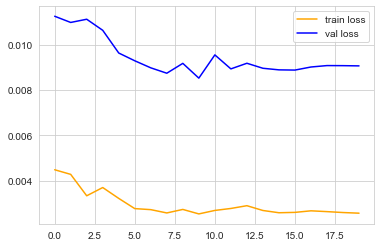

In [48]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='train loss', c='orange')
plt.plot(val_loss, label='val loss', c='blue')
plt.legend(loc='best')
plt.show()

### 3.2 Prediction on test set

In [49]:
## prediction
test_predict = model.predict(test_X)


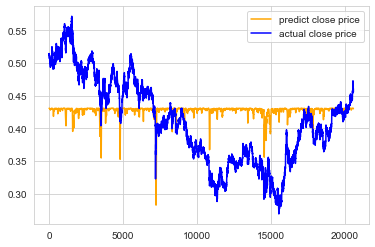

In [50]:
# prediction plots

plt.plot(test_predict, label='predict close price', c='orange')
plt.plot(test_y, label='actual close price', c='blue')
plt.legend(loc='best')
plt.show()

In [51]:
## model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print('RMSE: ', mean_squared_error(test_y, test_predict, squared=False))
print('MAPE: ', mean_absolute_percentage_error(test_y, test_predict))
print('MAE:  ', mean_absolute_error(test_y, test_predict))

RMSE:  0.06741349455454128
MAPE:  0.14842758602712094
MAE:   0.056840791213727204


### Attention Decoder
ref. https://github.com/ningshixian/LSTM_Attention

```
model = Sequential()
model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
model.add(AttentionDecoder(150, n_features))
model.compile(optimizer='adam', optimizer='adam', metrics=['val_loss'])
```

### Questions:
1. indicators based on closing price???  
For those important indicators that contain information of close price, which is the prediction target, for example in TA-Lib documentation,   
```
real = ROC(close, timeperiod=10)
real = ADX(high, low, close, timeperiod=14)
```   
Do we avoid using these kinds of indicators,   
OR change the close parameter to OHL (if so, will financial interpretations be different?),   
OR neve mind?

2. indicators???  
In many cases, the correlation value between INDICATOR and CLOSE is under 0.1 (abs value)

